In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [3]:
df = pd.read_csv('arrhythmia.data', usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 279],
                 names=['AGE', 'SEX', 'WEIGHT', 'QRS DURATION', 'P-R INTERVAL', 'Q-T INTERVAL',
                        'T INTERVAL', 'P INTERVAL', 'VA of QRS', 'VA of T', 'VA of P',
                        'VA of QRST', 'VA of J', 'HEART RATE', 'CLASS'])

прочитали данные, и добавили названия колонок, поскольку в файле нет заголовка

In [4]:
df = df.replace(to_replace='?', value=np.nan)

заменили значения '?' на NaN, чтоб pandas регистрировал их как пропущеные данные

In [5]:
df = df.astype('float64')

изменили тип на числовой, потому как он был object за счет смешаных числовых типов и значений '?'

In [6]:
# import pandas_profiling
# df.profile_report()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
AGE             452 non-null float64
SEX             452 non-null float64
WEIGHT          452 non-null float64
QRS DURATION    452 non-null float64
P-R INTERVAL    452 non-null float64
Q-T INTERVAL    452 non-null float64
T INTERVAL      452 non-null float64
P INTERVAL      452 non-null float64
VA of QRS       452 non-null float64
VA of T         444 non-null float64
VA of P         430 non-null float64
VA of QRST      451 non-null float64
VA of J         76 non-null float64
HEART RATE      451 non-null float64
CLASS           452 non-null float64
dtypes: float64(15)
memory usage: 53.1 KB


замечаем, что в колонке VA of J ~80% пропущеных, поэтому будет не рационально ее использовать

In [8]:
df.drop(columns=['VA of J'], inplace=True)

In [9]:
df = df.fillna(df.mean())

заполнили пропущеные значения средним по колонке

прежде чем использовать наивный байес, посмотрим на зависимости наших переменных

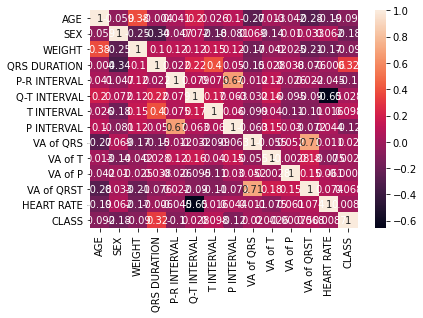

In [10]:
sns.heatmap(df.corr(), annot=True)

присутствует значимая кореляция переменных P INTERVAL и P-R INTERVAL,  
переменных VA of QRS и VA of QRST, и переменных Q-T INTERVAL и HEART RATE

In [11]:
X = df.drop(columns=['SEX', 'CLASS'])
y = df.CLASS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.values.ravel())
print(f'Точність моделі: {gnb.score(X_test, y_test)}')

Точність моделі: 0.6043956043956044


модель угадывает в 60% случаев

In [13]:
X1 = df.drop(columns=['SEX', 'CLASS', 'VA of QRST', 'P-R INTERVAL', 'Q-T INTERVAL'])
y1 = df.CLASS
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

In [14]:
gnb = GaussianNB()
gnb.fit(X1_train, y1_train.values.ravel())
print(f'Точність моделі: {gnb.score(X1_test, y1_test)}')

Точність моделі: 0.6813186813186813


если выкинуть сильно зависимые переменные, то имеем 68%

In [15]:
knn_search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [1, 3, 5, 10, 20]})
knn_search.fit(X_train, y_train.values.ravel())
knn = knn_search.best_estimator_
knn_search.best_params_

{'n_neighbors': 5}

использовав gridsearch, нашли подходящий параметр k = 5

In [16]:
print(f'Точність моделі: {knn.score(X_test, y_test)}')

Точність моделі: 0.6263736263736264


knn показывает чуть лучше, чем байес, но хуже, чем байес с независимыми предикторами

In [17]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
print(f'Точність моделі: {logit.score(X_test, y_test)}')

Точність моделі: 0.6373626373626373


применив логистическую регрессию, получаем примерно то же самое

теперь попробуем добавить факторную переменную

In [18]:
X = df.drop(columns=['CLASS'])
y = df.CLASS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f'Точність моделі: {gnb.score(X_test, y_test)}')

Точність моделі: 0.5824175824175825


видим, что фактор мешает классификатору.  
Причиной может быть то, что фактор имеет бинарное распределение.  
Попробуем байес с предположением о распределении Бернулли

In [20]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(f'Точність моделі: {bnb.score(X_test, y_test)}')

Точність моделі: 0.5494505494505495


результат не лучше

In [21]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print(f'Точність моделі: {knn.score(X_test, y_test)}')

Точність моделі: 0.6153846153846154


тут тоже хуже, чем без фактора

In [22]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
print(f'Точність моделі: {logit.score(X_test, y_test)}')

Точність моделі: 0.6483516483516484


а вот лог рег получил прибавку в ~0.01%

теперь попробуем отдельные выборки по фактору

In [23]:
df_male = df.loc[df['SEX'] == 0].drop('SEX', axis=1)
df_female = df.loc[df['SEX'] == 1].drop('SEX', axis=1)

In [24]:
X = df_male.drop(columns='CLASS')
y = df_male.CLASS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [25]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f'Точність моделі: {gnb.score(X_test, y_test)}')

Точність моделі: 0.3170731707317073


In [26]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print(f'Точність моделі: {knn.score(X_test, y_test)}')

Точність моделі: 0.3902439024390244


In [27]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
print(f'Точність моделі: {logit.score(X_test, y_test)}')

Точність моделі: 0.43902439024390244


результат по первой выборке хуже, чем общий

In [28]:
X = df_female.drop(columns='CLASS')
y = df_female.CLASS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [29]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f'Точність моделі: {gnb.score(X_test, y_test)}')

Точність моделі: 0.66


In [30]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.values.ravel())
print(f'Точність моделі: {knn.score(X_test, y_test)}')

Точність моделі: 0.64


In [31]:
logit = LogisticRegression()
logit.fit(X_train, y_train.values.ravel())
print(f'Точність моделі: {logit.score(X_test, y_test)}')

Точність моделі: 0.72


а по второй наоборот, лучше

видим, что модель лучше классифицирует женщин, чем мужчин